In [1]:
import numpy as np
import torch
import torchvision
from typing import Tuple

# Sieci neuronowe

## MNIST
Popularnym "prostym" datasetem, na którym można przetestować nasz model zanim zajmiemy się trudniejszymi problemami, jest MNIST, zbiór danych zawierających ręcznie rysowane cyfry. Poniżej kilka przykładowych cyfr:

<img width="400" src="https://miro.medium.com/proxy/0*At0wJRULTXvyA3EK.png" />


Zadanie naszego modelu polega na tym, by na podstawie obrazka narysowanej ręcznie cyfry określić, jaka to jest cyfra.

Czyli nasz model, widząc taki obrazek:
<img width="200" src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/sample_image.png" />

powinien odpowiedzieć, że to cyfra "7".


**Pytanie: Czy w takim sformułowaniu MNIST służy do regresji czy do klasyfikacji?**

## Praca na obrazkach
Nasze modele jak dotąd przyjmowały wyłącznie wektory - w jaki sposób możemy w takich modelach przetwarzać obrazki?

Obrazek to tak naprawdę trójwymiarowa tablica pikseli o wymiarach: `[H, W, C]`, gdzie `H` to wysokość, `W` to szerokość, a `C` to liczba kanałów (klasycznie: red, green, blue).

Najprostsze co możemy zrobić, to spłaszczyć naszą tablicę do jednego wymiaru, wektora o kształcie `[H * W * C]`. W przypadku MNIST-a nasze obrazki mają wymiar `28x28` pikseli i jest tylko jeden kanał (odcienie szarości), więc każdy z naszych wektorów będzie miał kształt `[28 * 28] = [784]`.

W przyszłości poznamy też sprytniejsze sposoby działania na obrazkach, np. za pomocą sieci konwolucyjnych.

## Stochastic gradient descent

Dotychczas kiedy chcieliśmy minimalizować funkcję kosztu $L(X; \theta)$ dla całego naszego zbioru $X \in \mathbb{R}^{NxD}$, liczyliśmy średni koszt dla wszystkich elementów $x \in X$, tzn. 

$$L(X; \theta) = \frac{1}{N} \sum_i L(x_i; \theta) $$

Następnie liczyliśmy gradient tego kosztu, żeby zminimalizować funkcję.

W praktyce może się okazać, że nasz dataset jest gigantyczny, np. kiedy mamy miliony przykładów. Niepraktyczne wtedy jest liczenie całego tego kosztu a tym bardziej gradientu. W praktyce w każdym kroku liczymy funkcję kosztu (i jej gradient) z innego podzbioru elementów w naszym zbiorze, czyli z tzw. **batcha**:

$$L_{\mathrm{batch}} (X;\theta) = \frac{1}{|B|} \sum_{x \in B} L(x; \theta) $$ 

Gradient po koszcie policzonym z batcha będzie inny niż gradient liczony po koszcie policzonym z całego zbioru, ale powinny być w miarę podobne, tzn:

$$ \nabla_\theta L_{\mathrm{batch}} (X; \theta) \approx \nabla_\theta L(X; \theta) $$

Metodę spadku gradientu zaimplementowaną w ten sposób (batchowo) nazywamy metodą **stochastycznego spadku gradientu** (*Stochastic Gradient Descent, SGD*). 


## Torchvision
PyTorch, a także pakiet `torchvision` udostępnia parę przydatnych narzędzi, z których skorzystamy na dzisiejszych zajęciach. Dla przykładu znacznie uproszczone jest pobieranie i ładowanie danych. W pakiecie [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html) znajdziemy popularne datasety, m.in. właśnie MNIST-a.

Oprócz tego z samego `torcha` możemy skorzystać z [`DataLoadera`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), który implementuje wiele przydatnych operacji do ładowania danych, np. dzielenie datasetu w batche i shufflowanie.

## Zadanie 1 (2 pkt.)
Klasa `MNIST` zwraca nam dane w postaci obiektów [PILa](https://pillow.readthedocs.io/en/stable/). Należy je odpowiednio przetworzyć, zanim będziemy mogli na nich pracować.

Za pomocą [`transformacji`](https://pytorch.org/vision/stable/transforms.html) podawanych do klasy MNIST należy:
1. Zamienić obiekty `PIL` w Tensory.  
2. Policzyć średnią i odchylenie standardowe pikseli dla całego zbioru trenującego i użyć ich do znormalizowania danych trenujących. Do liczenia średniej i odchylenia standardowego wykorzystać funkcję  `calculate_mean_and_std`.  
    **HINT**: Tutaj torchvision też powinien nam to ułatwić.  
3. Zmienić "kształt" każdego przykładu z `28x28` na `784`.  
    **HINT**: [`Lambda`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Lambda)

Uwaga: proszę zwrócić uwagę co dokładnie robią używane _transformacje_!

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import Normalize
from torchvision.transforms import Resize

def calculate_mean_and_std() -> Tuple[float, float]:
    train_data = MNIST(
        root='.',
        download=True,
        train=True, 
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((10,784))
        ])
    )
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in train_data:
        channels_sum += torch.mean(data, dim=[-1])
        channels_squared_sum += torch.mean(data**2, dim=[-1])
        num_batches += 1
    
    mean = torch.mean(channels_sum / num_batches)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    std = torch.std(std)
    return mean, std
mean, std = calculate_mean_and_std()

train_data = MNIST(
    root='.',
    download=False,
    train=True, 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(10,784)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean,std),
    ])
)
test_data = MNIST(
    root='.', 
    download=False, 
    train=False, 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(10,784)),
        torchvision.transforms.ToTensor(),
    ])
)

In [ ]:
mean, std = calculate_mean_and_std()
assert np.isclose(mean, 0.1306, atol=1e-4)
assert np.isclose(std, 0.3081, atol=1e-4)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

x, y = next(iter(train_loader))
assert len(x.shape) == 2
assert x.shape == (10, 784)

# Sieci neuronowe

### Modele liniowe
Jak dotąd przerabialiśmy wyłącznie modele liniowe, tzn. takie, które dla zadanego $x$ potrafiły modelować funkcję rodzaju $$f(x) = g(w^T x + b) $$
gdzie $x \in \mathbb{R}^D, w \in \mathbb{R}^D$, $b \in \mathbb{R}$ a $g$ to funkcja aktywacji, np. sigmoid.

Możemy też stworzyć podobny model, który na wyjściu nie będzie podawał jednej liczby, ale cały wektor o wymiarze $K$, tzn:
$$f(x) = g(W^T x + \mathbf{b}), $$
gdzie $W$ jest teraz macierzą a $\mathbf{b}$ wektorem, tzn. $W \in \mathbb{R}^{DxK}, \mathbf{b} \in \mathbb{R}^{K}$.

### Zanurzenia
Jeżeli chcieliśmy, żeby takie modele mogły zajmować się problemami nieliniowymi, musieliśmy znaleźć odpowiednią reprezentację danych (zanurzenia wielomianowe, kernele dla SVM-ów), które sprawi, że w nowej przestrzeni problem będzie liniowy. W tym celu trzeba "zgadnąć", jakie przekształcenie jest właściwe - co w przypadku bardziej skomplikowanych problemów jest niezwykle trudne. 

Ważne pytanie: **czy jesteśmy w stanie zbudować model, który znajdzie nam odpowiednią reprezentację dla danych?**

### Nakładanie warstw liniowych
**Rozwiązanie:** Nałóżmy na siebie kilka warstw modeli liniowych, np:
$$
f(x) = g_2(W_2^T (g_1(W_1^T x + \mathbf{b_1})) + \mathbf{b_2}),
$$
czyli, rozpisując czytelniej:
$$
f(x) = f^{(2)}(f^{(1)}(x)) \\
f^{(1)}(x) = g_1(W_1^T x + \mathbf{b_1}) \\ 
f^{(2)}(x) = g_2(W_2^T x + \mathbf{b_2})
$$

Powstały model nazywamy **sztuczną siecią neuronową** (*artificial neural network*).
 
Każdą funkcję $f^{(i)}$ nazywamy **warstwą** (*layer*). W naszej sieci możemy umieścić dowolnie wiele warstw, ale na razie będziemy zajmować się modelami nieszczególnie głębokimi (mniej niż 10 warstw).

Warstwy $f^{(i)}$ mogą implementować dowolną funkcję, ale jeśli mają postać $g(W^Tx +\mathbf{b})$, to nazywamy je warstwami liniowymi lub warstwami *fully connected*. Na tych zajęciach będziemy zajmować się wyłącznie sieciami o takiej postaci.


### Uczenie się reprezentacji
Jeśli nasz model jest postaci
$$
f(x) = f^{(n)}(f^{(n-1)}(\ldots f^{1}(x) \ldots )),
$$
to możemy przyjąć, że warstwa $f^{(n)}$ rozwiązuje problem liniowy na reprezentacji zadanej przez warstwy $f^{(1)}, f^{(2)}, \ldots, f^{(n-1)}$. 



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/1200px-Colored_neural_network.svg.png" width=300 />  

Źródło: [Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network).

### Neurony

**Neuron** w tym kontekście to fragment warstwy, który łączy się ze wszystkimi neuronami w poprzedniej warstwie i na ich podstawie produkuje jedno z wyjść warstwy. 

Jeśli nasza warstwa ma postać $g(W^T x + \mathbf{b})$, to $i$-ty neuron implementuje funkcję:
$$ f(x) = g(w_i^T x + b_i), $$
gdzie wektor $w_i$ jest $i$-tą kolumną macierzy $W$ a $b_i$ jest $i$-tym elementem wektora $\mathbf{b}$.

## Zadanie 2 (3 pkt.)
Za pomocą przygotowanego przez TensorFlow [narzędzia do zabawy z sieciami neuronowymi](http://playground.tensorflow.org) proszę przeprowadzić poniższe eksperymenty i opisać rezultaty.

Kilka uwag:
* Każda odpowiedź powinna być zawarta w jednym/dwóch zdaniach. 
* Punktowane będą nie tylko prawidłowe odpowiedzi, ale też sensowne hipotezy/przypuszczenia.
* Jeżeli proszeni są Państwo o podanie architektury sieci, to najlepiej zapisać ją w skrótowe postaci `n_1-n_2-...-n_k`, gdzie `n_i` to liczba neuronów w `i`-tej warstwie. Czyli jeśli sieć ma pięć neuronów w pierwszej warstwie, trzy neurony w drugiej warstwie oraz sześć neuronów w trzeciej warstwie, to można ją opisać jako `5-3-6`.
* Proszę nie zmieniać opcji noise/ratio of training to test data. Proszę nie zmieniać feature'ów wejściowych, o ile nie będzie to wyraźnie podane w zadaniu.
* Można użyć opcji "show test data", żeby sprawdzić, dlaczego koszt na datasecie treningowym i testowym się różni.

1) **Eksperymenty na zbiorze Gaussian**
* Czy ten dataset można rozwiązać metodami płytkimi, których uczyliśmy się na wcześniejszych zajęciach?
* Co sprawia, że ten zbiór danych jest łatwiejszy niż pozostałe?
* Porównaj na tym zbiorze dwa modele: sieć neuronową z kilkoma warstwami i kilkudziesięcioma neuronami oraz sieć z jednym neuronem. Który z tych modeli bardziej nadaje się do zadania?

### #######################################################################################################
# Tutaj należy opisać wyniki eksperymentów na zbiorze Gaussian.

**1**. Dataset można rozwiązać metodami płytkimi z poprzednich zajęć. Zaimplementowano sieć z pojedynczą warstwą, funckją aktywacji Sigmoid, regularyzacją L1 (regularization rate = 0.001). Model już po kilku epokach prawdiłowo rozwiązuje problem klasyfikacji datasetu Gaussian


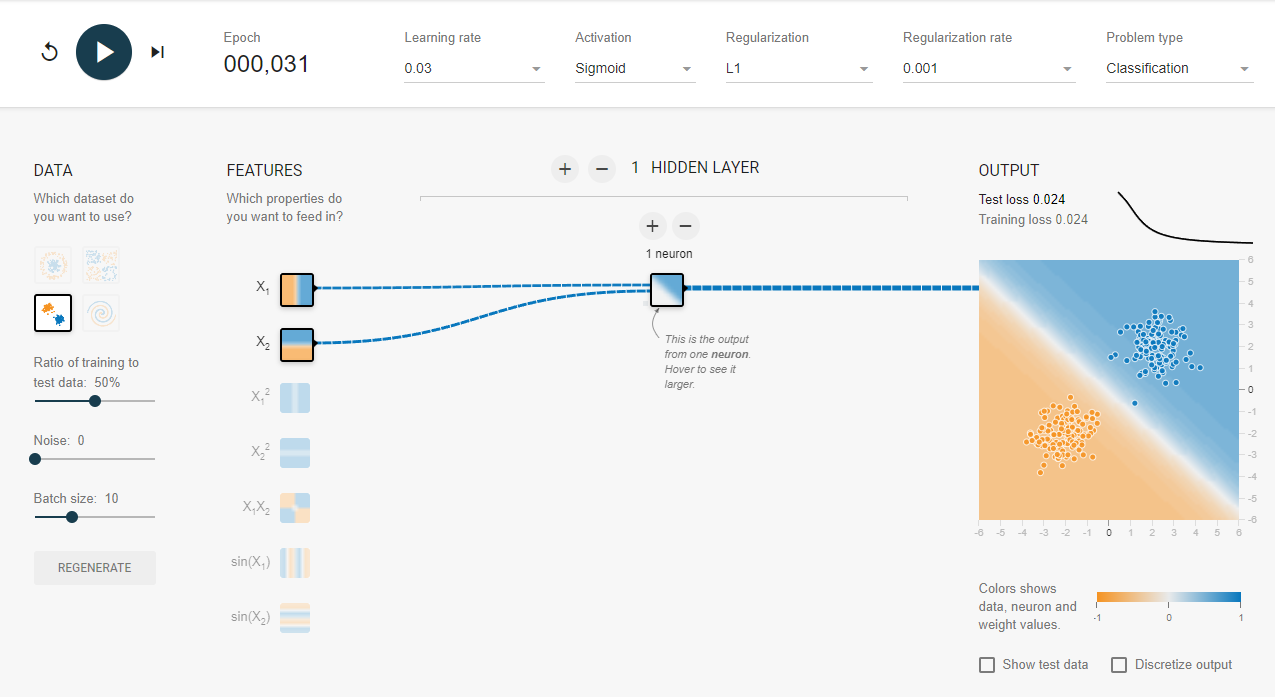

**2**. Zbiór danych *Gaussian* da się w prosty sposób rozdzielić liniowo dlatego też proste modele liniowe dobrze radzą sobie z tym problemem

**3**. Porównano sieć z podpunktu 1. z siecią o następującej architekturze: 5-7-2. W większej sieci satysfakcjonujące wyniki (prawidłową klasyfikację) udało się osiągnąć dopiero w okolicy dwusetnej epoki. Wskazuje to lepsze dopasowanie mniejszej sieci do tego zadania

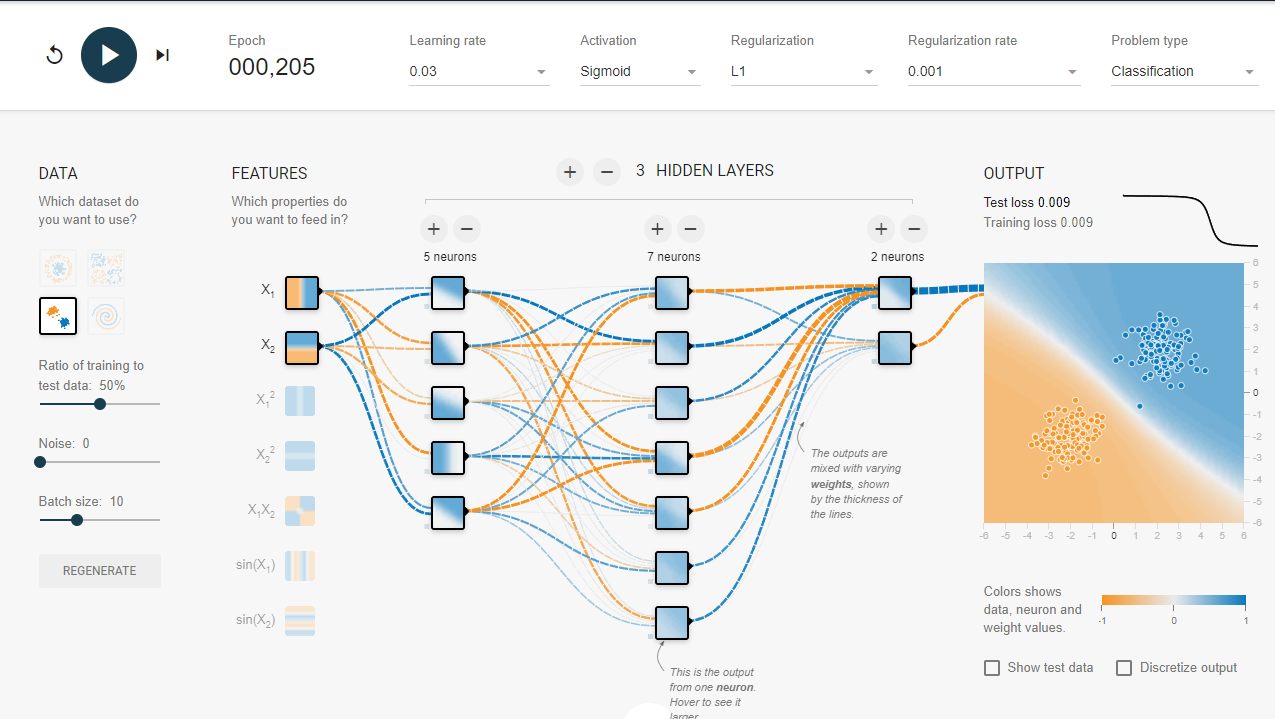

2) **Eksperymenty na zbiorze Circle**
* Załóżmy, że mamy sieć z jednym neuronem. Ile najmniej potrzeba feature'ów wejściowych, żeby model osiągał na datasecie testowym koszt $\leq 0.001$? Jakie to feature'y?
* Załóżmy, że na wejściu mamy tylko niezanurzone feature'y (tzn. $x_1$ oraz $x_2$). Stwórz najmniejszą sieć neuronową (pod względem liczby neuronów), która osiąga na datasecie testowym koszt $\leq 0.001$. Opisz architekturę tej sieci. 
* Spróbuj rozwiązać ten problem za pomocą dowolnie dużej sieci neuronowej **z aktywacjami liniowymi** (nie zmieniając feature'ów wejściowych). Czy udało się osiągnąć wynik $\leq 0.001$? Jeśli tak, podaj architekturę sieci. Jeśli nie, podaj hipotezę, dlaczego się nie udało.

# Tutaj należy opisać wyniki eksperymentów na zbiorze Circle.

1. Najmniejsza ilość featere'ów wejściowych do osiągnięcia kosztu $\leqslant 0.001$ na datasecie testowym wynosi **3**. Te feature'y to:
    1. $x_1^2$
    2. $x_2^2$
    3. $\sin(X_1)$

2. Stworzono sieć: 3-2-1, regularyzacja: L2, funkcja aktywacji: ReLU. Osiągnięto zadaną wartość kosztu w okolicy 800 - setnej epoki:

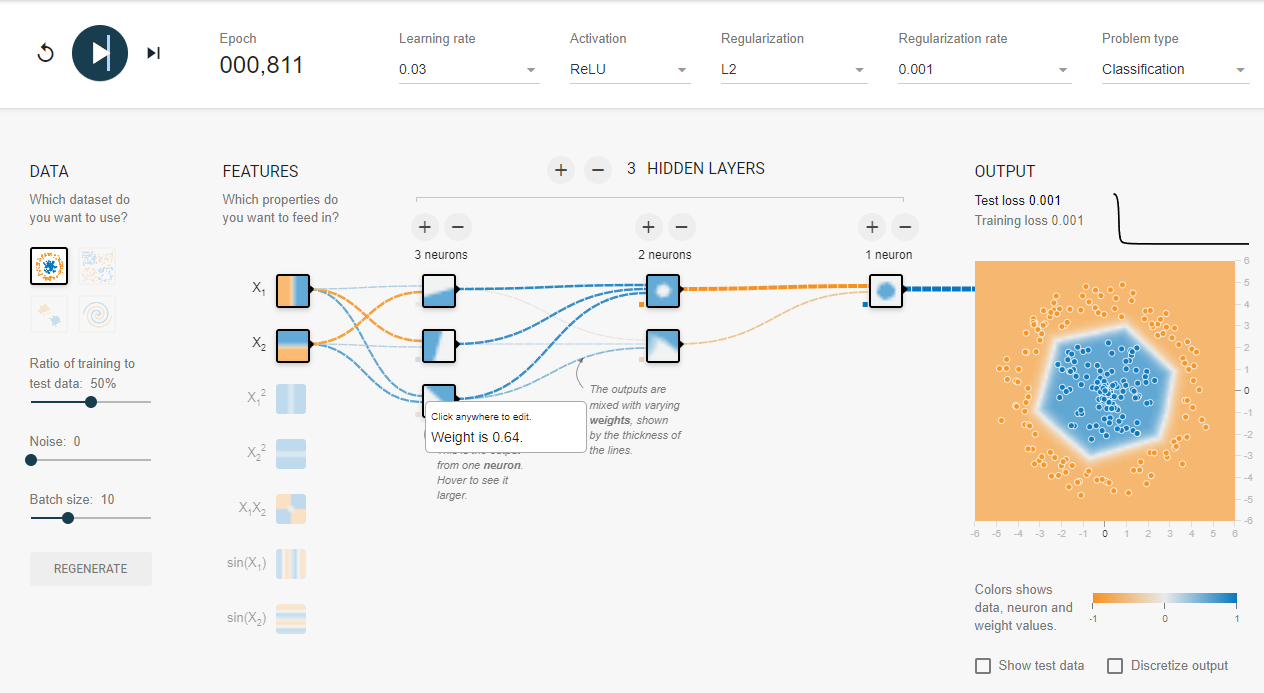

3. Problemu nie udało się rozwiązać przy użyciu liniowych funkcji aktywacji. Prawodopodobną hipotezą jest fakt, że problem *Circle* jest zadaniem nieliniowym więc w tym przypadku liniowe funkcje aktywacji nie będą prawidłowo go rozwiązywać, w porównaniu do ReLU bądź Sigmoid.

3) **Eksperymenty na zbiorze Spiral**
* Osiągnij (stabilny) koszt $\leq 0.1$ na zbiorze testowym, podaj wykorzystaną architekturę, rodzaj aktywacji, regularyzację  oraz learning rate.
* Co odróżnia rozwiązania które dobrze generalizują od rozwiązań, które overfitują pod względem wizualnym? Popatrz na płaszczyznę z danymi po wytrenowaniu modelu.

# Tutaj należy opisać wyniki eksperymentów na zbiorze Spiral.
1. Po przetestowaniu kilku wariantów wybrano najbardziej optymalnie klasyfikujący model: 7-7-5-4, aktywacja: ReLU, learning rate = 0.03, przy wykorzystaniu wszystkich parametrów

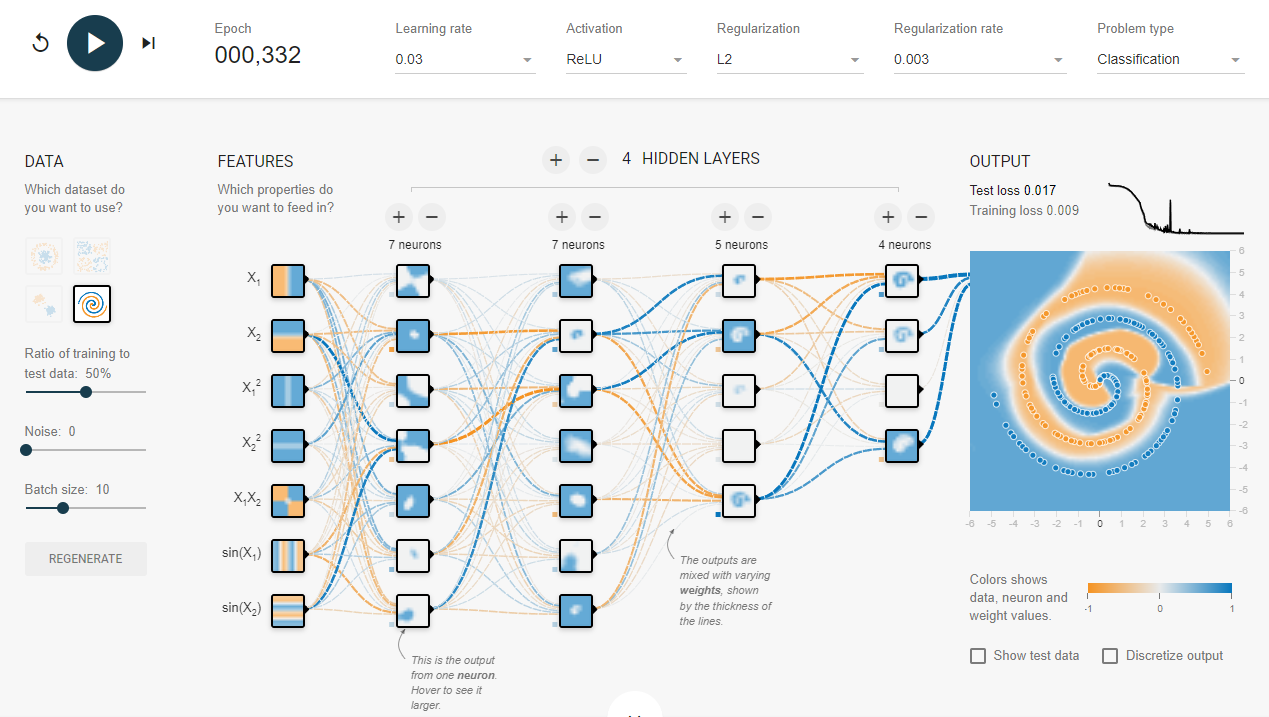

2. Rozwiązania, ktore zbytnio dopasowują się do danych treningowych są podatne na dane, które są spoza ich zakresu (outliery, różne struktury danych walidacyjnych/produkcyjnych). Widać to na płaszczyźnie problemu *Spiral* załączonej powyżej - dane, które pojawią się poza zakresem danych treningowych (tu: poza spiralą) zostaną błędnie zaklasyfikowane. 

### #######################################################################################################

## Zadanie 3 (2 pkt.)

Ręcznie zaimplementować prostą sieć z jedną warstwą ukrytą. Sieć:
1. Na wejściu będzie przyjmować dane o wymiarze `input_dim`
2. Pierwsza warstwa ma je przetwarzać na wymiar `hidden_dim`.
3. Druga warstwa ma przetwarzać wyjście pierwszej warstwy na wymiar `output_dim`.

W tym celu trzeba stworzyć odpowiednie tensory reprezentujące wagi i biasy w poszczególnych warstwach
1. Macierze wag należy zainicjalizować za pomocą wartości wylosowanych ze standardowego rozkładu normalnego. 
2. Dla obu warstw należy stworzyć _biasy_ zainicjalizowane na 0.
3. Funkcją aktywacji dla pierwszej warstwy ma być `torch.tanh`. W drugiej warstwie ma być aktywacja liniowa (czyli brak aktywacji).

Następnie należy zaimplementować pętlę uczenia z użyciem PyTorchowej funkcji kosztu `nn.CrossEntropyLoss` i optymalizatora SGD. Jeśli wszystko zostało zaimplementowane poprawne, to sieć powinna zazwyczaj osiagać accuracy większe niż `0.82` na zbiorze testowym (chociaż czasami może nie osiągać tej wartości z powodu pechowej inicjalizacji).

**HINT** Proszę nie zapomnieć o `requires_grad=True` przy definiowaniu parametrów sieci.

In [8]:
from typing import List

class CustomNetwork(object):
    """
    Simple 1-hidden layer linear neural network
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize network's weights 
        """
        
        self.weight_1: torch.Tensor = ???
        self.bias_1: torch.Tensor = ???
        
        self.weight_2: torch.Tensor = ???
        self.bias_2: torch.Tensor = ???
        
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        ???
        
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return [self.weight_1, self.bias_1, self.weight_2, self.bias_2]

In [1]:
from torch import nn
from torch.optim import SGD
from torch.nn.functional import cross_entropy

# some hyperparams
batch_size: int = 64
epoch: int = 3


# prepare data loaders, based on the already loaded datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# initialize the model
model: CustomNetwork = ???

# initialize the optimizer using the hyperparams below
lr: float = 0.01
momentum: float = 0.9
optimizer: torch.optim.Optimizer = SGD(???)

criterion = nn.CrossEntropyLoss()

# training loop
for e in range(epoch):
    for i, (x, y) in enumerate(train_loader):
        # reset the gradients from previouis iteration
        optimizer.zero_grad()
        # pass through the network
        output: torch.Tensor = ???
        # calculate loss
        loss: torch.Tensor = criterion(???)
        # backward pass thorught the network
        loss.backward()
        # apply the gradients
        optimizer.step()
        
        # log the loss value
        if (i + 1) % 100 == 0:
            print(f"Epoch {e} iter {i+1}/{len(train_data) // batch_size} loss: {loss.item()}", end="\r")
            
    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        # initialize the number of correct predictions
        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network
            output: torch.Tensor = ???
            # update the number of correctly predicted examples
            correct += ???

        print(f"\nTest accuracy: {correct / len(test_data)}")

        
# this is your test
assert correct / len(test_data) > 0.82, "Subject to random seed you should be able to get >82% accuracy"